In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from flows import MaskingDense, IAF, MAF
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
batch_size = 256
# 生成的z的维度。如果要训练，则考虑选择更大的dim
latent_dim = 32
num_flow = 5
learning_rate = 0.0005
dropout = 0.1

dataset_path = r"C:\Users\i9233\recommend system\dataset\hetrec2011-lastfm-2k"
hottest = int(math.pow(25, 2))

In [3]:
user_representation_normalized = pd.read_csv(dataset_path + "\\user_representation_sigmoid.csv" )
item_representation = pd.read_csv(dataset_path + "\\item_representation_1.csv" )

In [4]:
dataset_len = user_representation_normalized.shape[0]
target = np.zeros(dataset_len)

train_data = tf.data.Dataset.from_tensor_slices((tf.cast(user_representation_normalized.values, 'float32'), target))

train_data = train_data.repeat().batch(batch_size).prefetch(1)

In [5]:
dataset_len = item_representation.shape[0]
target = np.zeros(dataset_len)

train_data = tf.data.Dataset.from_tensor_slices((tf.cast(item_representation.values, 'float32'), target))

train_data = train_data.repeat().batch(batch_size).prefetch(1)

In [6]:
maf = MAF(original_size=hottest, latent_dim=latent_dim, num_flow=num_flow)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [7]:
# 训练maf
def train_maf(maf, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
    loss_list = []
    for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
        with tf.GradientTape() as g:
            z_k, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
            x_hat, _z_sigmas_2 = maf.generation(z_k)
            # 收敛非常快，暂时不知道原因
            loss = maf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)
            
        loss_list.append(loss)
        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
        gradients = g.gradient(loss, maf.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, maf.variables))
    return loss_list

In [8]:
# 测试代码
dataset=train_data
training_steps=50
display_step=10

loss_list = []
for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
    with tf.GradientTape() as g:
        z_k, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
        x_hat, _z_sigmas_2 = maf.generation(z_k)
            # 收敛非常快，暂时不知道原因
        loss = maf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)
            
    loss_list.append(loss)
    if step % display_step == 0:
        print("step: %i, loss: %f" % (step, loss))
    gradients = g.gradient(loss, maf.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, maf.variables))

    
maf.metric(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(x_hat)) * hottest

det = _z_log_sigma_0
for z_sigma in _z_sigmas:
    det += tf.keras.backend.log(z_sigma)
logqz_x = -tf.keras.backend.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)

tf.reduce_mean(logqz_x)

tf.reduce_mean(-tf.keras.backend.sum(0.5 * np.log(2*math.pi) + 0.5 * z_k ** 2, axis=-1))

KeyboardInterrupt: 

step: 0, loss: 357.586090
step: 2000, loss: -280.149200
step: 4000, loss: -287.718567
step: 6000, loss: -287.385803
step: 8000, loss: -283.586578
step: 10000, loss: -280.291779
step: 12000, loss: -282.748352
step: 14000, loss: -271.749298
step: 16000, loss: -266.550323
step: 18000, loss: -291.929993
step: 20000, loss: -292.454010


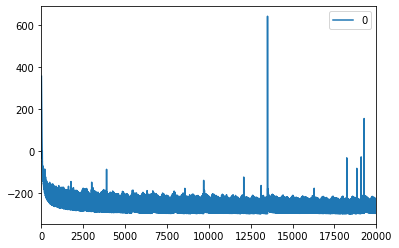

In [9]:
training_steps = 20000
display_step = 2000
loss_list = train_maf(maf, dataset=train_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [10]:
place = "./models/maf/item_sigmoid_BinaryCrossentropy_%d_%d_%d/" % (latent_dim, training_steps, num_flow)
tf.saved_model.save(maf, place)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/maf/item_sigmoid_BinaryCrossentropy_32_20000_5/assets


In [11]:
place = "./models/maf/item_sigmoid_BinaryCrossentropy_%d_%d_%d/" % (latent_dim, training_steps, num_flow)
maf = tf.saved_model.load(place)

In [11]:
iaf = IAF(original_size=hottest, latent_dim=latent_dim, num_flow=num_flow)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [12]:
def train_iaf_with_trained_maf(iaf, maf, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
    loss_list = []
    for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
        with tf.GradientTape() as g:
            z_k, e_0, _z_log_sigma_0, _z_sigmas2 = maf.inference(inputs)
            
            z_k_i, e_0, _z_log_sigma_0, _z_sigmas = iaf.inference(inputs)
            
            x_hat, _z_sigmas = iaf.generation(z_k_i) # 不计算会说有些没有训练到，故而注释掉
            
            iaf_loss = iaf.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k_i)
            
            # CAF eq 20。最后一层的sigma，代表z自身的熵 
            H_z = tf.reduce_mean(np.log(2*math.pi * _z_sigmas[-1]))
            # CAF eq 21。maf和iaf生成的熵
            
            # 交叉熵最好先做归一化，如果不归一化，这里的z的预测会急剧变成全负数。目前考虑的是用sigmoid
            # 在正常训练中没有出现，是因为会保证其z约束在正态分布上。联合训练也会负，但是不快
            z_k = tf.math.sigmoid(z_k)
            z_k_i = tf.math.sigmoid(z_k_i)
            H_maf_iaf = tf.reduce_mean(tf.keras.metrics.binary_crossentropy(z_k_i, z_k))
            
            loss =  H_z + H_maf_iaf + iaf_loss
            # 使用联合训练，iaf的loss下降很快，这里可以加入和直接iaf训练的对比图。因为求导的性质，也不需要担心对各个loss的减小的性能
            loss_list.append(iaf_loss)
        if step % display_step == 0:
            print("step: %i, H_z: %f, H_maf_iaf: %f, iaf_loss: %f" % (step, H_z, H_maf_iaf, iaf_loss))
        gradients = g.gradient(loss, iaf.variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, iaf.variables))
    return loss_list

step: 0, H_z: 1.379366, H_maf_iaf: 0.809571, iaf_loss: 3234.875977
step: 2000, H_z: 1.479357, H_maf_iaf: 0.788907, iaf_loss: 126.860809
step: 4000, H_z: 1.507720, H_maf_iaf: 0.790160, iaf_loss: 120.846893
step: 6000, H_z: 1.517319, H_maf_iaf: 0.789263, iaf_loss: 121.659851
step: 8000, H_z: 1.521359, H_maf_iaf: 0.785815, iaf_loss: 119.229858
step: 10000, H_z: 1.523115, H_maf_iaf: 0.785550, iaf_loss: 125.989464
step: 12000, H_z: 1.523894, H_maf_iaf: 0.791534, iaf_loss: 124.799660
step: 14000, H_z: 1.524261, H_maf_iaf: 0.797571, iaf_loss: 133.797562
step: 16000, H_z: 1.524429, H_maf_iaf: 0.799137, iaf_loss: 140.726532
step: 18000, H_z: 1.524524, H_maf_iaf: 0.788381, iaf_loss: 118.166458
step: 20000, H_z: 1.524569, H_maf_iaf: 0.783900, iaf_loss: 116.268417


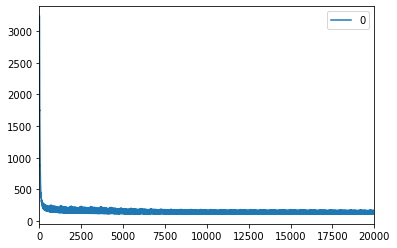

In [13]:
training_steps = 20000
display_step = 2000
loss_list = train_iaf_with_trained_maf(iaf, maf, dataset=train_data, optimizer=optimizer, 
                                       training_steps=training_steps, display_step=display_step)

p = pd.DataFrame(loss_list)
p.plot()

In [14]:
place = "./models/iaf/item_sigmoid_BinaryCrossentropy_%d_%d_%d/" % (latent_dim, training_steps,num_flow)
tf.saved_model.save(iaf, place)

INFO:tensorflow:Assets written to: ./models/iaf/item_sigmoid_BinaryCrossentropy_32_20000_5/assets
